In [1]:
import pandas as pd


In [2]:
data = pd.read_parquet("datasets/final/dataset_v2.parquet")

In [3]:
data.head()

,code,key,tglang
2,\n# syntax: GAWK -f ASCENDING_PRIMES.AWK\nBEG...,11,TGLANG_LANGUAGE_AWK
3,\n// Ascending primes. Nigel Galloway: April ...,36,TGLANG_LANGUAGE_FSHARP
5,"package main\n \nimport (\n ""fmt""\n ""rcu...",39,TGLANG_LANGUAGE_GO
8,using Combinatorics\nusing Primes\n \nfunction...,51,TGLANG_LANGUAGE_JULIA
9,local function is_prime(n)\n if n < 2 then re...,57,TGLANG_LANGUAGE_LUA


In [4]:
used_keys = list(
    map(
        lambda x: x[0],
        filter(
            lambda x: x[1] >= 2,
            ((key, value) for key, value in data["key"].value_counts().items())
        )
    )
)

len(used_keys)

99

In [5]:
data = data[data["key"].isin(used_keys)]
data.shape

(67427, 3)

In [6]:
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import train_test_split
# import numpy as np

# class RandomModel:
#     def __init__(self):
#         pass
#     def fit(self, X, y):
#         self.X = X
#         self.y = y

#         self.targets = np.fromiter(np.unique(y), dtype=int)

#         return self
#     def predict(self, X):
#         return np.random.choice(self.targets, len(X))

In [7]:
# X_train, X_test, y_train, y_test = train_test_split(data["code"], data["key"], test_size=0.10, random_state=137)

# random_model = RandomModel()
# random_model.fit(X_train, y_train)
# y_predict = random_model.predict(X_test)

# accuracy_score(y_test, y_predict)

In [8]:
# """
#     Надо бы засемплировать кусочки
# """
# data.columns, data.shape

In [9]:
snippets_cols = ["code", "tglang", "target"]
snippets_data = []

for row_idx, row in data.reset_index().iterrows():
    code = row["code"].strip()
    tglang = row["tglang"]
    target = row["key"]

    code_lines = code.split("\n")

    tmp_idx = 0
    tmp_snippet = []
    tmp_chars = 0

    for line_idx, line in enumerate(code_lines):
        line_chars = len(line)

        if tmp_chars + line_chars > 4096:
            snippets_data.append(
                [
                    "\n".join(tmp_snippet),
                    tglang,
                    target
                ]
            )
    
            tmp_snippet = [line]
            tmp_chars   = line_chars
            tmp_idx     = line_idx
        else:
            tmp_snippet.append(line)
            tmp_chars += line_chars

    snippets_data.append(
        [
            "\n".join(code_lines[tmp_idx:]),
            tglang,
            target
        ]
    )

snippets = pd.DataFrame(snippets_data, columns=snippets_cols)
snippets.shape

(386392, 3)

<AxesSubplot:>

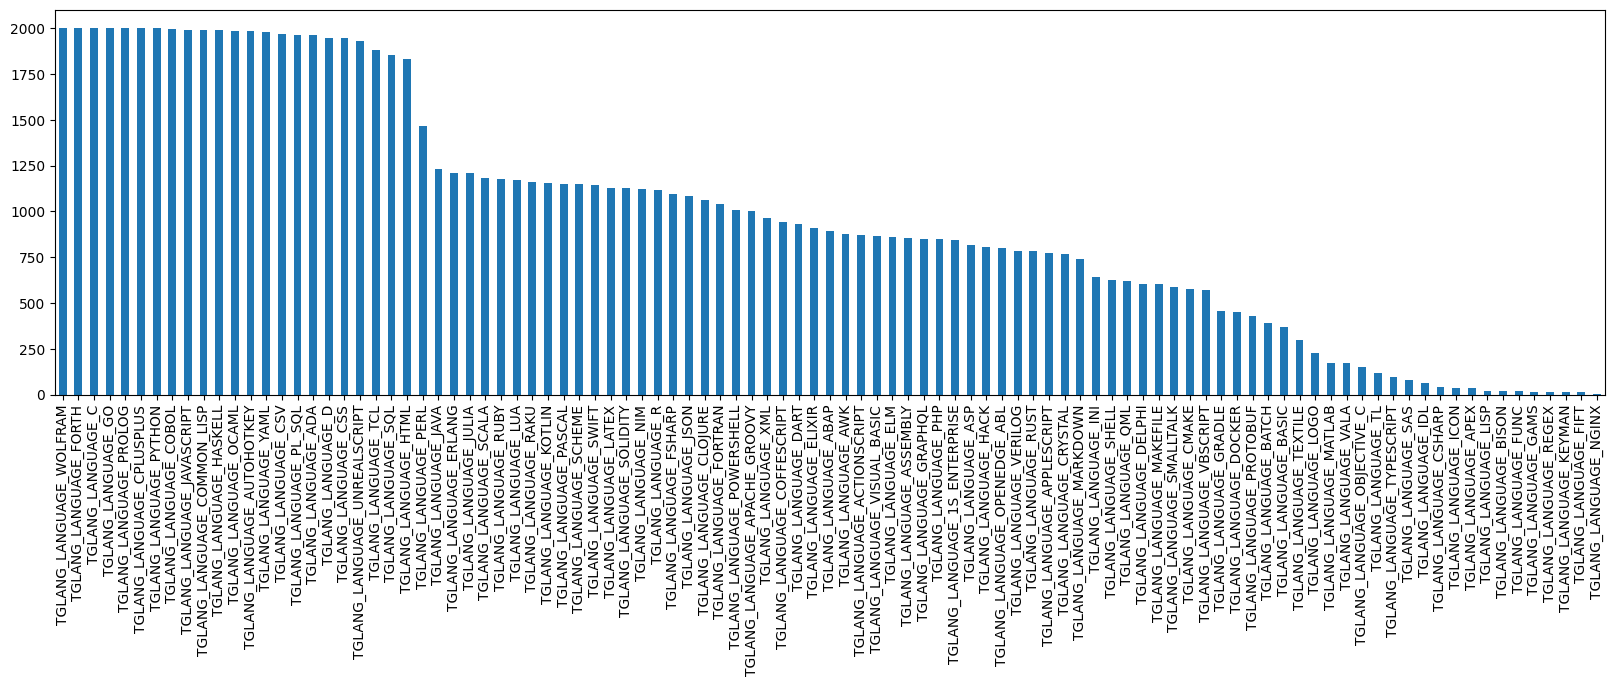

In [11]:
def custom_sampling(group):
    k = 2000

    if group.shape[0] > k:
        return group.sample(n=k, random_state=137, replace=False)
    return group.sample(n=k, random_state=137, replace=True)

snippets_smapled = snippets[snippets["code"] != ""]
snippets_smapled = snippets_smapled\
    .groupby(["tglang", "target"])\
    .apply(custom_sampling)\
    .drop_duplicates()

snippets_smapled["tglang"].value_counts().plot(kind='bar', figsize = (20,5))

In [12]:
snippets_smapled.shape

(96753, 3)

In [ ]:
# for row_idx, row in snippets_smapled.sample(n = 3).iterrows():
#     print("=-=-==-=-=-=-==-=-=-=-=-=-=-=")
#     print(row["code"])

In [ ]:
# import re

# example = """
# package main
# import "fmt"
# import "regexp"
 
# func main() {
#   str := "I am the original string"
 
#   // Test
#   matched, _ := regexp.MatchString(".*string$", str)
#   if matched { fmt.Println("ends with 'string'") }
 
#   // Substitute
#   pattern := regexp.MustCompile("original")
#   result := pattern.ReplaceAllString(str, "modified")
#   fmt.Println(result)
# }
# """

# "".join(re.split(
#     r"""(\b[A-Za-z_]\w*\b|[!\#\$%\&\*\+:\-\./<=>\?@\\\^_\|\~]+|[ \t\(\),;\{\}\[\]`"'])""",
#     example
# ))

In [ ]:
# from sklearn.linear_model import SGDClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import LinearSVC
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.multiclass import OneVsRestClassifier

# sgd = SGDClassifier(loss="log_loss")
# svc = LinearSVC()

# from sklearn.metrics import accuracy_score,hamming_loss,precision_score,recall_score,f1_score
# def print_metrics_report(clf,y_test,y_pred):
#     print("Clf: ", clf.__class__.__name__)
#     print('Exact Match Ratio: {0}'.format(np.round(accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)*100,2)))
#     print('Accuracy: {0}'.format(accuracy_score(y_test, y_pred)))
#     print('Hamming loss: {0}'.format(np.round(hamming_loss(y_test, y_pred)*100,2))) 
#     print('Recall: {0}'.format(np.round(precision_score(y_test, y_pred, average='micro')*100,2)))
#     print('Precision: {0}'.format(np.round(recall_score(y_test,y_pred, average='micro')*100,2)))
#     print('F1 Measure: {0}'.format(np.round(f1_score(y_test, y_pred, average='micro')*100,2))) 
#     print('-------------')
#     print("")

In [ ]:
# token_pattern = r"""(\b[A-Za-z_]\w*\b|[!\#\$%\&\*\+:\-\./<=>\?@\\\^_\|\~]+|[ \t\(\),;\{\}\[\]`"'])"""

# def preprocess(x):
#     return pd.Series(x).replace(r'\b([A-Za-z])\1+\b', '', regex=True)\
#         .replace(r'\b[A-Za-z]\b', '', regex=True)

# def preprocess_2(x):
#     return pd.Series(x).apply(
#         lambda x: "".join(
#             re.split(
#                 r"""(\b[A-Za-z_]\w*\b|[!\#\$%\&\*\+:\-\./<=>\?@\\\^_\|\~]+|[ \t\(\),;\{\}\[\]`"'])""",
#                 x
#             )
#         )
#     )

# snippets_processed = snippets_smapled.copy()
# snippets_processed["code"] = preprocess(snippets_processed["code"])
# print("preprocess done..")
# # snippets_processed["code"] = preprocess_2(snippets_processed["code"])
# # print("preprocess preprocess_2..")

In [ ]:
# snippets_processed.head(3)

In [ ]:
# """
#     Нужно поисграть с параметрами
# """

# from sklearn.linear_model import LogisticRegression
# token_pattern = r"""(\b[A-Za-z_]\w*\b|[!\#\$%\&\*\+:\-\./<=>\?@\\\^_\|\~]+|[ \t\(\),;\{\}\[\]`"'])"""

# def preprocess(x):
#     return pd.Series(x).replace(r'\b([A-Za-z])\1+\b', '', regex=True)\
#         .replace(r'\b[A-Za-z]\b', '', regex=True)

# # param_grid = [    
# #     {
# #         'logreg__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
# #         'logreg__C' : np.logspace(-4, 4, 20),
# #         'logreg__solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
# #         'logreg__max_iter' : [100, 1000,2500, 5000]
# #     }
# # ]

# param_grid = [    
#     {
#         'logreg__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
#         # 'logreg__C' : np.logspace(-4, 4, 20),
#         'logreg__solver' : ['liblinear', 'saga'],
#         'logreg__max_iter' : [100]
#     }
# ]

# from sklearn.model_selection import GridSearchCV

# logModel = LogisticRegression()

# transformer = FunctionTransformer(preprocess)
# vectorizer = TfidfVectorizer(token_pattern=token_pattern, max_features=3000)

# pipe_RF = Pipeline([
#     ('preprocessing', transformer),
#     ('vectorizer', vectorizer),
#     ('logreg', logModel)]
# )

# clf = GridSearchCV(pipe_RF,
#                    param_grid=param_grid,
#                    cv=4,
#                    verbose=5,
#                    n_jobs=-1)

# X_train_gs, X_test_gs, y_train_gs, y_test_gs = train_test_split(
#     snippets_processed["code"],
#     snippets_processed["target"], test_size=0.10, random_state=137)

# best_clf = clf.fit(X_train_gs, y_train_gs)

In [ ]:
# best_clf.best_estimator_

In [ ]:
# print(f'Accuracy: {best_clf.score(X_test_gs, y_test_gs)}')

In [ ]:
# from sklearn.datasets import make_classification
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.experimental import enable_halving_search_cv  # noqa
# from sklearn.model_selection import HalvingGridSearchCV

# param_grid = [    
#     {
#         'logreg__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
#         # 'logreg__C' : np.logspace(-4, 4, 20),
#         'logreg__solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
#         'logreg__max_iter' : [100]
#     }
# ]

# from sklearn.linear_model import LogisticRegression
# token_pattern = r"""(\b[A-Za-z_]\w*\b|[!\#\$%\&\*\+:\-\./<=>\?@\\\^_\|\~]+|[ \t\(\),;\{\}\[\]`"'])"""

# def preprocess(x):
#     return pd.Series(x).replace(r'\b([A-Za-z])\1+\b', '', regex=True)\
#         .replace(r'\b[A-Za-z]\b', '', regex=True)

# from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer = TfidfVectorizer(
#     token_pattern=token_pattern,
#     max_features=3000)

# X_train_val, X_test, y_train_val, y_test = train_test_split(
#     snippets_processed["code"],
#     snippets_processed["target"], test_size=0.10, random_state=137)
# print("TrainVal / Test split done..")

# X_train, X_val, y_train, y_val = train_test_split(
#     X_train_val,
#     y_train_val, test_size=0.10, random_state=137)
# print("Train / Val split done..")

# X_train = preprocess(X_train)
# X_val   = preprocess(X_val)
# X_test  = preprocess(X_test)
# print("Processing done..")

# vectorizer.fit(X_train)
# print("Fit vectorizer done..")

# X_train = vectorizer.predict(X_train)
# X_val   = vectorizer.predict(X_val)
# X_test  = vectorizer.predict(X_test)
# print("Vectorization done..")

# from sklearn.model_selection import GridSearchCV

# logreg = LogisticRegression()
# logreg_cv = GridSearchCV(
#     logreg,
#     param_grid,
#     cv=10
# )
# logreg_cv.fit(x_train, y_train)

# print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
# print("accuracy :",logreg_cv.best_score_)

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf = TfidfVectorizer(
#     max_features=3000,
#     ngram_range=(1),
#     token_pattern=token_pattern
# )

# X_train, X_test, y_train, y_test = train_test_split(
#     snippets_processed["code"],
#     snippets_processed["target"], test_size=0.10, random_state=137)
# print("Split done..")

# tfidf = tfidf.fit(X_train)
# print("Train done..")

# X_train = tfidf.transform(X_train)
# X_test  = tfidf.transform(X_test)

# X_train.shape, X_test.shape

In [ ]:
# for classifier in [sgd]:
#     clf = OneVsRestClassifier(classifier)
#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
#     print_metrics_report(classifier,y_test,y_pred)

In [ ]:
# ngram_range=(1, 3) 78%

In [ ]:
# model_0 = clf.estimators_[0]
# model_0.n_features_in_, model_0.coef_

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
# from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline

token_pattern = r"""(\b[A-Za-z_]\w*\b|[!\#\$%\&\*\+:\-\./<=>\?@\\\^_\|\~]+|[ \t\(\),;\{\}\[\]`"'])"""

def preprocess(x):
    return pd.Series(x).replace(r'\b([A-Za-z])\1+\b', '', regex=True)\
        .replace(r'\b[A-Za-z]\b', '', regex=True)

# Pipe steps
# transformer = FunctionTransformer(preprocess)
vectorizer = TfidfVectorizer(token_pattern=token_pattern, max_features=3000)
dataset = snippets_smapled.copy()
dataset["code"] = preprocess(dataset["code"])

X_val, X_test, y_val, y_test = train_test_split(
    dataset["code"],
    dataset["target"],
    test_size=0.10,
    random_state=137,
    shuffle=True,
    stratify=dataset["target"]
)

X_val.shape, X_test.shape

((87077,), (9676,))

In [50]:
"""
    Заранее подготовим фолды
"""

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, random_state=137, shuffle=True)

fold_datasets = []

for i, (train_index, test_index) in enumerate(skf.split(X_val, y_val)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}", len(train_index))
    print(f"  Test:  index={test_index}", len(test_index))

    train_x_fold = X_val[train_index]
    test_x_fold  = X_val[test_index]

    train_y_fold = y_val[train_index]
    test_y_fold  = y_val[test_index]

    vectorizer = TfidfVectorizer(token_pattern=token_pattern, max_features=3000)
    vectorizer.fit(train_fold)

    fold_datasets.append(
        (vectorizer.transform(train_x_fold),
         vectorizer.transform(test_x_fold),
         train_y_fold,
         test_y_fold)
    )

Fold 0:
  Train: index=[    0     1     2 ... 87074 87075 87076] 69661
  Test:  index=[    3    13    19 ... 87063 87064 87073] 17416
Fold 1:
  Train: index=[    1     2     3 ... 87073 87075 87076] 69661
  Test:  index=[    0     8    15 ... 87061 87068 87074] 17416
Fold 2:
  Train: index=[    0     1     3 ... 87073 87074 87075] 69662
  Test:  index=[    2     4     7 ... 87067 87070 87076] 17415
Fold 3:
  Train: index=[    0     1     2 ... 87073 87074 87076] 69662
  Test:  index=[   10    12    18 ... 87065 87071 87075] 17415
Fold 4:
  Train: index=[    0     2     3 ... 87074 87075 87076] 69662
  Test:  index=[    1     5     6 ... 87066 87069 87072] 17415


In [59]:
from itertools import product
from statistics import mean
from custom_random_forest import CustomRandomForestClassifier as RandomForestClassifier

grid_params = {
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt'],
    'min_samples_split': [2, 3, 4, 8],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [50, 300],
    'max_depth': [80, 100, None]
}
# debug
# grid_params = {
#     'criterion': ['gini'],
#     'max_features': ['sqrt'],
#     'min_samples_split': [2],
#     'min_samples_leaf': [1],
#     'n_estimators': [50, 100],
#     'max_depth': [2]
# }

param_names = list(grid_params.keys())
param_values = (zip(param_names, x) for x in product(*grid_params.values()))

best_params = {}
best_accuracy = -1

for paramset in param_values:
    kwargs = dict(paramset)
    print(kwargs)

    clf = RandomForestClassifier(n_jobs=4, **kwargs)

    params_accuracy = []

    for train_x_fold, test_x_fold, train_y_fold, test_y_fold in fold_datasets:
        clf.fit(train_x_fold, train_y_fold)
        params_accuracy.append(clf.score(test_x_fold, test_y_fold))

    print("Fold accuracy", params_accuracy)
    print("Accuracy", mean(params_accuracy))

    if mean(params_accuracy) > best_accuracy:
        best_params = kwargs
        best_accuracy = mean(params_accuracy)

print("best_params", best_params)
print("best_accuracy", best_accuracy)

{'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 50, 'max_depth': 80}
Fold accuracy [0.9130110243454295, 0.9109439595774, 0.9076083835773758, 0.9123169681309217, 0.9075509618145277]
Accuracy 0.9102862594891309
{'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 50, 'max_depth': 100}
Fold accuracy [0.9164561322921452, 0.9110587965089573, 0.9136376686764284, 0.9161642262417456, 0.9099052540913006]
Accuracy 0.9134444155621154
{'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 50, 'max_depth': None}
Fold accuracy [0.9165709692237023, 0.9166858061552595, 0.9148435256962388, 0.9171978179730118, 0.9127189204708585]
Accuracy 0.9156034079038142
{'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 300, 'max_depth': 80}
Fold accuracy [0.9231166743224621, 0.9200734956361

KeyboardInterrupt: 

In [ ]:
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 50, 'max_depth': 10}
# Fold accuracy [0.3595544327055581, 0.3771819016995866, 0.36675279931093885, 0.3059431524547804, 0.35113407981625033]
# Accuracy 0.35211327319742286
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 50, 'max_depth': 20}
# Fold accuracy [0.5925011483693156, 0.6215548920532843, 0.5832902670111972, 0.6009187482055699, 0.6200401952339937]
# Accuracy 0.6036610501746721
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 50, 'max_depth': 40}
# Fold accuracy [0.8514010105649977, 0.8596118511713366, 0.856732701693942, 0.859603789836348, 0.8550100488084984]
# Accuracy 0.8564718804150245
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 50, 'max_depth': 80}
# Fold accuracy [0.9110013780431787, 0.9105420303169499, 0.909158771174275, 0.911972437553833, 0.908641975308642]
# Accuracy 0.9102633184793757
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 50, 'max_depth': 100}
# Fold accuracy [0.9132406982085439, 0.9153651814423519, 0.9136376686764284, 0.9140396210163652, 0.9111111111111111]
# Accuracy 0.9134788560909601
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 50, 'max_depth': None}
# Fold accuracy [0.9173748277446027, 0.9129536058796509, 0.9130634510479472, 0.9165087568188344, 0.9123743898937697]
# Accuracy 0.914455006276961
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 100, 'max_depth': 10}
# Fold accuracy [0.3364722094625632, 0.33980248047772166, 0.37266724088429515, 0.37662934252081537, 0.3494114269308068]
# Accuracy 0.35499654005524045
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 100, 'max_depth': 20}
# Fold accuracy [0.5989894350022967, 0.6139182361047313, 0.6395061728395062, 0.6191214470284238, 0.6075796726959518]
# Accuracy 0.615822992734182
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 100, 'max_depth': 40}
# Fold accuracy [0.8736793752870923, 0.8631143775838309, 0.8671260407694517, 0.8760838357737583, 0.8597760551248923]
# Accuracy 0.867955936907805
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 100, 'max_depth': 80}
# Fold accuracy [0.9184657785943959, 0.9162838768948094, 0.9150157909847833, 0.9191501579098479, 0.9133505598621877]
# Accuracy 0.9164532328492049
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 100, 'max_depth': 100}
# Fold accuracy [0.9220831419384474, 0.9185806155259532, 0.9174275050244043, 0.921619293712317, 0.918288831467126]
# Accuracy 0.9195998775336496
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 100, 'max_depth': None}
# Fold accuracy [0.9232315112540193, 0.9208199356913184, 0.9186333620442148, 0.9231122595463681, 0.9194946884869365]
# Accuracy 0.9210583514045714
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 300, 'max_depth': 10}
# Fold accuracy [0.33038585209003213, 0.3965319246669729, 0.3789836347975883, 0.37772035601492965, 0.3820844099913867]
# Accuracy 0.3731412355121819
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 300, 'max_depth': 20}
# Fold accuracy [0.6480248047772164, 0.6422829581993569, 0.6260694803330462, 0.6383577375825438, 0.6331897789262131]
# Accuracy 0.6375849519636753
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 300, 'max_depth': 40}
# Fold accuracy [0.8751722553973358, 0.8768948093706936, 0.8720643123743899, 0.8776342233706574, 0.869710020097617]
# Accuracy 0.8742951241221387
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 300, 'max_depth': 80}
# Fold accuracy [0.9238056959118053, 0.9223128158015618, 0.9201837496411139, 0.92213608957795, 0.9183462532299742]
# Accuracy 0.921356920832481
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 300, 'max_depth': 100}
# Fold accuracy [0.9266192007349564, 0.9247243913642628, 0.9225380419178869, 0.925983347688774, 0.9219064025265575]
# Accuracy 0.9243542768464875
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 300, 'max_depth': None}
# Fold accuracy [0.9273082223242995, 0.9243224621038126, 0.9247200689061155, 0.927418891759977, 0.9222509331036463]
# Accuracy 0.9252041156395702
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 600, 'max_depth': 10}
# Fold accuracy [0.38039733578318785, 0.39050298576022047, 0.38771174275050246, 0.38834338214183173, 0.38225667527993107]
# Accuracy 0.3858424243431347
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 600, 'max_depth': 20}
# Fold accuracy [0.62132521819017, 0.6407326596233348, 0.6331897789262131, 0.6455354579385587, 0.6438702268159633]
# Accuracy 0.6369306682988479
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 600, 'max_depth': 40}
# Fold accuracy [0.8770670647680294, 0.8769522278364722, 0.8763709445879988, 0.8772896927935687, 0.8693080677576802]
# Accuracy 0.8753975995487498
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 600, 'max_depth': 80}
# Fold accuracy [0.9249540652273771, 0.9215089572806615, 0.9207005455067471, 0.9228251507321275, 0.9204708584553546]
# Accuracy 0.9220919154404535
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 50, 'max_depth': 80}
# Fold accuracy [0.9130110243454295, 0.9109439595774, 0.9076083835773758, 0.9123169681309217, 0.9075509618145277]
# Accuracy 0.9102862594891309
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 50, 'max_depth': 100}
# Fold accuracy [0.9164561322921452, 0.9110587965089573, 0.9136376686764284, 0.9161642262417456, 0.9099052540913006]
# Accuracy 0.9134444155621154
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 50, 'max_depth': None}
# Fold accuracy [0.9165709692237023, 0.9166858061552595, 0.9148435256962388, 0.9171978179730118, 0.9127189204708585]
# Accuracy 0.9156034079038142
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 300, 'max_depth': 80}
# Fold accuracy [0.9231166743224621, 0.9200734956361966, 0.9199540625897215, 0.9227677289692794, 0.9175997703129486]
# Accuracy 0.9207023463661216
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 300, 'max_depth': 100}
# Fold accuracy [0.9250689021589343, 0.9243224621038126, 0.9223657766293425, 0.9263853000287109, 0.9213321848980763]
# Accuracy 0.9238949251637754
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 300, 'max_depth': None}
# Fold accuracy [0.9275378961874139, 0.9251263206247129, 0.9231696813092162, 0.9265001435544071, 0.9223083548664944]
# Accuracy 0.9249284793084489
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 2, 'n_estimators': 50, 'max_depth': 80}
# Fold accuracy [0.8957854846118511, 0.8926848874598071, 0.8950330175136376, 0.898535745047373, 0.8925638817111685]
# Accuracy 0.8949206032687674
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 2, 'n_estimators': 50, 'max_depth': 100}
# Fold accuracy [0.8975654570509876, 0.8961874138723014, 0.8957795004306632, 0.9008900373241459, 0.8947459086993971]
# Accuracy 0.8970336634754991
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 2, 'n_estimators': 50, 'max_depth': None}
# Fold accuracy [0.9005512172714745, 0.9007234726688103, 0.8944013781223084, 0.8997416020671835, 0.8928509905254092]
# Accuracy 0.8976537321310372
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 2, 'n_estimators': 300, 'max_depth': 80}
# Fold accuracy [0.9097381717960497, 0.9063504823151125, 0.9059431524547804, 0.90961814527706, 0.9030720643123744]
# Accuracy 0.9069444032310754
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 2, 'n_estimators': 300, 'max_depth': 100}
# Fold accuracy [0.9103123564538356, 0.9079007808911346, 0.9070915877117427, 0.912029859316681, 0.9061728395061729]
# Accuracy 0.9087014847759134
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 2, 'n_estimators': 300, 'max_depth': None}
# Fold accuracy [0.9119200734956362, 0.9080156178226918, 0.9074935400516796, 0.9117427505024405, 0.9043927648578811]
# Accuracy 0.9087129493460658
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 4, 'n_estimators': 50, 'max_depth': 80}
# Fold accuracy [0.8808566835094166, 0.8777560863573726, 0.8770600057421762, 0.8799885156474304, 0.875968992248062]
# Accuracy 0.8783260567008916
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 4, 'n_estimators': 50, 'max_depth': 100}
# Fold accuracy [0.8820050528249885, 0.8820050528249885, 0.8788975021533161, 0.8845248349124318, 0.873557278208441]
# Accuracy 0.8801979441848332
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 4, 'n_estimators': 50, 'max_depth': None}
# Fold accuracy [0.8808566835094166, 0.8785599448782728, 0.8791271892047086, 0.882227964398507, 0.8745334481768591]
# Accuracy 0.8790610460335528
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 4, 'n_estimators': 300, 'max_depth': 80}
# Fold accuracy [0.8939480937069362, 0.8895268718419844, 0.8905541200114844, 0.8925638817111685, 0.8857881136950905]
# Accuracy 0.8904762161933328
# {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 4, 'n_estimators': 300, 'max_depth': 100}
# Fold accuracy [0.8949816260909509, 0.8920532843362425, 0.8912431811656618, 0.8949181739879414, 0.8869365489520529]
# Accuracy 0.8920265629065699

In [19]:
clf = RandomForestClassifier(n_jobs=4, max_depth=2)

from pprint import pprint
print('Parameters currently in use:\n')
pprint(clf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 4,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [20]:
best_params = {
    'clf__criterion': 'gini',
    'clf__max_features': 'sqrt',
    'clf__min_samples_split': 3,
    'clf__n_estimators': 300
}
pipe_RF = Pipeline([
    # ('preprocessing', transformer),
    ('vectorizer', vectorizer),
    ('clf', clf)]
)
pipe_RF.set_params(**best_params)

X_train_, X_test_, y_train_, y_test_ = train_test_split(
    snippets_smapled["code"],
    snippets_smapled["target"],
    test_size=0.2,
    random_state=137)

# Fitting
pipe_RF.fit(X_train_, y_train_)

# Evaluation
print(f'Accuracy: {pipe_RF.score(X_test_, y_test_)}') # 0.9277556715415224

Accuracy: 0.049609839284791485
